<a href="https://colab.research.google.com/github/ali1810/Solubility_Prediction/blob/main/Solu_Fingerprints_DEsc_DEc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

     |████████████████████████████████| 288 kB 5.3 MB/s 
     |████████████████████████████████| 15.5 MB 47.7 MB/s 
     |████████████████████████████████| 1.7 MB 29.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 113 kB 57.9 MB/s 
     |████████████████████████████████| 6.8 MB 17.7 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 167 kB 37.9 MB/s 
     |████████████████████████████████| 261 kB 50.8 MB/s 
     |████████████████████████████████| 1.3 MB 51.2 MB/s 
     |████████████████████████████████| 2.0 MB 27.4 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 102 kB 11.2 MB/s 
     |████████████████████████████████| 62 kB 751 kB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
     |███████████████████

In [ ]:
from pycaret.regression import *

In [ ]:
### Installation of condacolab to install rdkit ....
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:30
🔁 Restarting kernel...


In [ ]:
### Installing RDKIT 

#!mamba install -c conda-forge rdkit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
#data=pd.read_csv('/content/drive/MyDrive/KIT/delaney.csv')
#data=pd.read_csv('/content/drive/MyDrive/KIT/delaney_and_water.csv')

#data1=pd.read_csv('/content/drive/MyDrive/KIT/curated-solubility-dataset_new.csv')
#data1=pd.read_csv('/content/drive/MyDrive/KIT/ESOL_delaney-processed.csv')
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
smiles_array=data.SMILES
#smiles_array1=data1.Smiles

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Fingerprints import FingerprintMols

from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen

In [ ]:
#Turning SMILES into Explicit Bit Vectors (RDKit prefered format)
mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in smiles_array]


#Convert training molecules into training fingerprints
bi = {}
fingerprints = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=512) for m in mols]

#Convert training fingerprints into binary, and put all training binaries into arrays
import numpy as np 

fingerprints_array = []
for fingerprint in fingerprints:
        array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(fingerprint, array)
        fingerprints_array.append(array)



In [ ]:
### Write a function to calculate these values....

def getAromaticProportion(m):
    aromatic_list = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aromatic = 0
    for i in aromatic_list:
        if i:
            aromatic += 1
    heavy_atom = Lipinski.HeavyAtomCount(m)
    return aromatic / heavy_atom


def generate(smiles):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:

        desc_MolLogP = Crippen.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Lipinski.NumRotatableBonds(mol)
        desc_AromaticProportion = getAromaticProportion(mol)
        desc_Ringcount        =   Descriptors.RingCount(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_Hdonrs=Lipinski.NumHDonors(mol)
        desc_SaturatedRings = Lipinski.NumSaturatedRings(mol)   
        desc_AliphaticRings = Lipinski.NumAliphaticRings(mol) 
        desc_HAcceptors  =     Lipinski.NumHAcceptors(mol)
        desc_Heteroatoms =    Lipinski.NumHeteroatoms(mol)
        desc_Max_Partial_Charge =  Descriptors.MaxPartialCharge(mol)
        desc_FP_density =  Descriptors.FpDensityMorgan1(mol)
        desc_num_valence_electrons = Descriptors.NumValenceElectrons(mol)
        #desc_molMR=Descriptors.MolMR(mol)
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion,desc_Ringcount,desc_TPSA,desc_Hdonrs,desc_SaturatedRings,desc_AliphaticRings,
                        desc_HAcceptors,desc_Heteroatoms,
                        desc_Max_Partial_Charge,desc_num_valence_electrons,desc_FP_density])#,desc_num_valence_electrons])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MolP","MolWt", "NumRotatableBonds", "AromaticProportion"
                  ,"Ring_Count","TPSA","H_donors", "Saturated_Rings","AliphaticRings","H_Acceptors","Heteroatoms","Max_Partial_Charge",
                  "valence_electrons","FP_density"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [ ]:
df=generate(smiles_array)
#descriptors =generate(smiles_array)
print(df)

         MolP    MolWt  ...  valence_electrons  FP_density
0     2.59540  167.850  ...               38.0    1.166667
1     2.37650  133.405  ...               32.0    1.200000
2     2.59380  167.850  ...               38.0    0.666667
3     2.02890  133.405  ...               32.0    1.400000
4     2.91890  187.375  ...               50.0    0.875000
...       ...      ...  ...                ...         ...
1139  1.98820  287.343  ...               96.0    1.375000
1140  3.42130  286.114  ...               94.0    1.277778
1141  3.60960  308.333  ...              116.0    1.086957
1142  2.56214  354.815  ...              122.0    1.217391
1143  2.02164  179.219  ...               70.0    1.230769

[1144 rows x 14 columns]


In [ ]:
fingerprints_array=pd.DataFrame(fingerprints_array)
df1=pd.concat([fingerprints_array,df],axis=1)
#df1
#df1 = np.append(fingerprints_array, df, axis = 1)
#df1.shape

In [ ]:
df2=pd.concat([data,df1],axis=1)

#df2 = np.append(data, df1, axis = 1)
#df2

In [ ]:
Y = df2.iloc[:,1].rename("LogS")
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: LogS, Length: 1144, dtype: float64

In [ ]:
dataset = pd.concat([df1,Y],axis=1)
#dataset=np.append(df1,Y,axis=1)
#dataset.to_csv("/content/drive/MyDrive/KIT/delaney_processed_14_fingerprints.csv",index=False)
dataset.shape

(1144, 527)

In [ ]:
model = setup(data=dataset,target="LogS",train_size=0.8,silent=True)

,Description,Value
0,session_id,1986
1,Target,LogS
2,Original Data,"(1144, 527)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,512
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(915, 526)"


In [ ]:
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4459,3.697000e-01,0.6074,9.124000e-01,0.1730,0.4215,0.205
et,Extra Trees Regressor,0.4522,3.855000e-01,0.6191,9.088000e-01,0.1773,0.4951,2.831
gbr,Gradient Boosting Regressor,0.4829,4.072000e-01,0.6374,9.038000e-01,0.1897,0.4922,0.591
rf,Random Forest Regressor,0.4794,4.382000e-01,0.6605,8.964000e-01,0.1895,0.5443,2.181
ada,AdaBoost Regressor,0.6316,6.458000e-01,0.8019,8.476000e-01,0.2291,0.5327,0.527
br,Bayesian Ridge,0.6297,6.983000e-01,0.8328,8.358000e-01,0.2350,0.7125,0.389
huber,Huber Regressor,0.6418,7.263000e-01,0.8476,8.299000e-01,0.2459,0.7268,0.378
dt,Decision Tree Regressor,0.6765,8.893000e-01,0.9374,7.904000e-01,0.2589,0.7930,0.064
knn,K Neighbors Regressor,0.7000,9.160000e-01,0.9518,7.864000e-01,0.2597,0.7276,0.097
omp,Orthogonal Matching Pursuit,0.7367,9.475000e-01,0.9708,7.768000e-01,0.2855,0.8829,0.046


In [ ]:
model = create_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4408,0.4144,0.6438,0.9054,0.1725,0.2725
1,0.4658,0.3736,0.6112,0.9057,0.1723,1.2788
2,0.4266,0.3247,0.5698,0.9329,0.1691,0.3464
3,0.4422,0.3493,0.5911,0.9279,0.1500,0.1882
4,0.4357,0.3344,0.5783,0.9205,0.1622,0.2270
5,0.4974,0.4398,0.6631,0.9131,0.2051,0.3742
6,0.4493,0.3726,0.6104,0.8991,0.1673,0.4052
7,0.4604,0.3919,0.6260,0.9057,0.1876,0.2806
8,0.4111,0.3622,0.6018,0.8940,0.1790,0.5378
9,0.4294,0.3344,0.5783,0.9200,0.1654,0.3046


In [ ]:
tuned_model = tune_model(model, n_iter =120, optimize = 'mae')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4602,0.4046,0.6361,0.9076,0.1747,0.2621
1,0.4203,0.3034,0.5508,0.9234,0.1585,1.4550
2,0.4018,0.3006,0.5483,0.9379,0.1513,0.3536
3,0.4785,0.3976,0.6305,0.9179,0.1696,0.2151
4,0.3935,0.2977,0.5456,0.9292,0.1566,0.2410
5,0.4995,0.4528,0.6729,0.9105,0.2136,0.4161
6,0.4518,0.3775,0.6144,0.8978,0.1824,0.4851
7,0.4358,0.3832,0.6190,0.9078,0.1815,0.3188
8,0.3993,0.3431,0.5858,0.8996,0.1801,0.4501
9,0.4195,0.3242,0.5694,0.9225,0.1689,0.3458


In [ ]:
predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4768,0.4858,0.697,0.8954,0.1836,0.5033


,MolP,MolWt,NumRotatableBonds,AromaticProportion,Ring_Count,TPSA,H_donors,Saturated_Rings,AliphaticRings,H_Acceptors,Heteroatoms,Max_Partial_Charge,valence_electrons,FP_density,0_0,1_0,2_1,3_0,4_1,5_0,6_1,7_0,8_0,9_0,10_0,11_0,12_1,13_1,14_1,15_0,16_0,17_0,17_1,18_0,19_0,19_1,20_0,21_1,22_0,23_0,...,475_0,476_1,477_1,480_0,481_0,482_0,483_1,484_0,485_0,485_1,486_0,487_0,487_1,488_0,489_0,490_1,491_1,492_0,492_1,493_0,494_0,494_1,495_1,496_1,497_0,497_1,498_1,499_1,500_1,501_0,502_0,505_1,506_0,507_1,508_0,509_0,510_1,511_0,LogS,Label
0,4.84010,344.494995,1.0,0.000000,4.0,43.369999,0.0,3.0,4.0,3.0,3.0,0.302687,138.0,1.040000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-5.284,-4.961015
1,1.68380,248.307007,2.0,0.705882,2.0,86.180000,2.0,0.0,0.0,4.0,5.0,0.206092,88.0,0.647059,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-3.094,-3.449713
2,3.77020,274.412994,9.0,0.000000,0.0,18.459999,0.0,0.0,0.0,5.0,6.0,0.246843,86.0,1.071429,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-4.230,-4.168409
3,1.94750,116.204002,3.0,0.000000,0.0,20.230000,1.0,0.0,0.0,1.0,1.0,0.059132,50.0,1.375000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-1.080,-1.283599
4,0.40480,198.222000,2.0,0.000000,1.0,75.269997,2.0,1.0,1.0,3.0,5.0,0.327632,78.0,1.142857,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-2.210,-2.095561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0.13430,133.197006,0.0,0.000000,1.0,29.100000,1.0,1.0,1.0,3.0,4.0,0.235340,38.0,1.857143,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-1.770,-1.419941
225,1.94750,116.204002,3.0,0.000000,0.0,20.230000,1.0,0.0,0.0,1.0,1.0,0.061665,50.0,1.375000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-0.980,-1.211160
226,4.95360,250.339005,0.0,0.545455,1.0,0.000000,0.0,0.0,0.0,0.0,5.0,0.080845,60.0,0.636364,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-5.650,-5.667604
227,2.95952,254.289001,0.0,0.631579,3.0,55.560001,1.0,0.0,1.0,3.0,4.0,0.261417,96.0,1.105263,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1

In [ ]:
final_model = finalize_model(tuned_model)
predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0668,0.0081,0.09,0.9983,0.0337,0.0948


,MolP,MolWt,NumRotatableBonds,AromaticProportion,Ring_Count,TPSA,H_donors,Saturated_Rings,AliphaticRings,H_Acceptors,Heteroatoms,Max_Partial_Charge,valence_electrons,FP_density,0_0,1_0,2_1,3_0,4_1,5_0,6_1,7_0,8_0,9_0,10_0,11_0,12_1,13_1,14_1,15_0,16_0,17_0,17_1,18_0,19_0,19_1,20_0,21_1,22_0,23_0,...,475_0,476_1,477_1,480_0,481_0,482_0,483_1,484_0,485_0,485_1,486_0,487_0,487_1,488_0,489_0,490_1,491_1,492_0,492_1,493_0,494_0,494_1,495_1,496_1,497_0,497_1,498_1,499_1,500_1,501_0,502_0,505_1,506_0,507_1,508_0,509_0,510_1,511_0,LogS,Label
0,4.84010,344.494995,1.0,0.000000,4.0,43.369999,0.0,3.0,4.0,3.0,3.0,0.302687,138.0,1.040000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-5.284,-5.266757
1,1.68380,248.307007,2.0,0.705882,2.0,86.180000,2.0,0.0,0.0,4.0,5.0,0.206092,88.0,0.647059,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-3.094,-3.067523
2,3.77020,274.412994,9.0,0.000000,0.0,18.459999,0.0,0.0,0.0,5.0,6.0,0.246843,86.0,1.071429,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-4.230,-4.206546
3,1.94750,116.204002,3.0,0.000000,0.0,20.230000,1.0,0.0,0.0,1.0,1.0,0.059132,50.0,1.375000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-1.080,-1.066909
4,0.40480,198.222000,2.0,0.000000,1.0,75.269997,2.0,1.0,1.0,3.0,5.0,0.327632,78.0,1.142857,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-2.210,-2.161955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0.13430,133.197006,0.0,0.000000,1.0,29.100000,1.0,1.0,1.0,3.0,4.0,0.235340,38.0,1.857143,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-1.770,-1.831191
225,1.94750,116.204002,3.0,0.000000,0.0,20.230000,1.0,0.0,0.0,1.0,1.0,0.061665,50.0,1.375000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-0.980,-1.017936
226,4.95360,250.339005,0.0,0.545455,1.0,0.000000,0.0,0.0,0.0,0.0,5.0,0.080845,60.0,0.636364,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-5.650,-5.575275
227,2.95952,254.289001,0.0,0.631579,3.0,55.560001,1.0,0.0,1.0,3.0,4.0,0.261417,96.0,1.105263,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1

In [ ]:
save_model(final_model,"/content/drive/MyDrive/KIT/WaterSoulubility01DEC21_14_fingerprints_99.83")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='LogS',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.7,
                                importance_type='split', learning_rate=0.05,
                                max_depth=-1, min_child_samples=1,
                    

In [ ]:
model = load_model("/content/drive/MyDrive/KIT/WaterSoulubility01DEC21_14_fingerprints_99.83")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
smiles = []
smiles.append("S(C)c1nc(NC(C)C)nc(NC(C)C)n1")
smiles.append("O=[N+]([O-])C1C(=O)NC(=O)NC1=O")
smiles.append("Clc1cc2C(=NC(O)C(=O)Nc2cc1)c1ccccc1")
smiles.append("C(CC)(CC)(C)C")
smiles.append("C(=C)CCCCCCCC")
smiles.append("S(=O)(=O)(NC(=O)NCCCC)c1ccccc1")
smiles.append("O=[N+]([O-])c1cc(C(=O)O)ccc1")
smiles.append("O=c1oc2c(c(C)c1)ccc(N(CC)CC)c2")
smiles.append("Fc1ccc(C(=O)CCCN2CCC(O)(c3ccc(C)cc3)CC2)cc1")
smiles.append("Clc1c(S(=O)(=O)N)cc2C(=O)NC(CC)Nc2c1")



In [ ]:
mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in smiles]


#Convert training molecules into training fingerprints
bi = {}
fingerprints = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=512) for m in mols]

import numpy as np 

fingerprints_array = []
for fingerprint in fingerprints:
        array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(fingerprint, array)
        fingerprints_array.append(array)

x = generate(smiles)
fingerprints_array=pd.DataFrame(fingerprints_array)
X=pd.concat([fingerprints_array,x],axis=1)
X[0:]
model.predict(X[0:])

array([-3.99369505, -1.77019977, -3.90919537, -4.27379821, -5.49152158,
       -2.62616803, -1.87999132, -3.7634712 , -4.87018112, -3.22734711])

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
pip install matplotlib 2.0.2 

ERROR: Could not find a version that satisfies the requirement 2.0.2
ERROR: No matching distribution found for 2.0.2


In [ ]:
from yellowbrick.regressor import ResidualsPlot

In [1]:
evaluate_model(final_model)

NameError: ignored

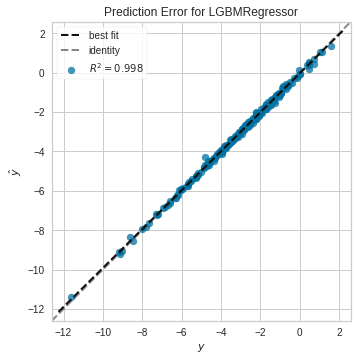

In [ ]:
plot_model(final_model, plot = 'error')

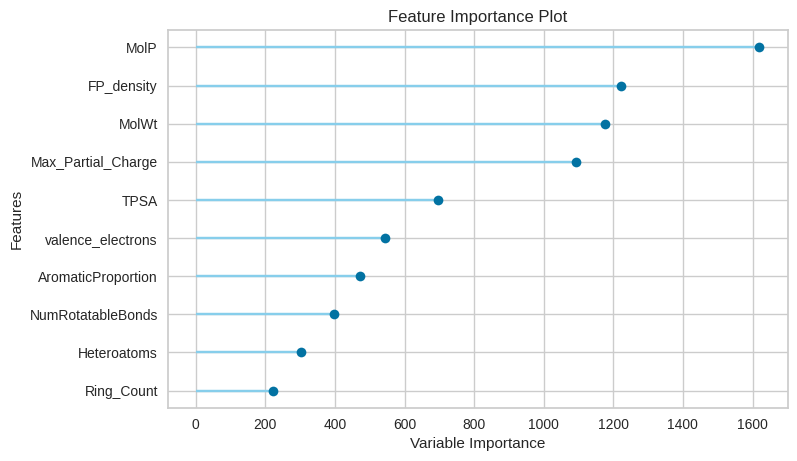

In [ ]:
plot_model(final_model, plot='feature')